# Ejercicios de C-Means

### Daniel Marín López

---

### Importación de librerías

In [ ]:
!pip install scikit-fuzzy
!pip install kneed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from skfuzzy.cluster import cmeans as Cmeans
from kneed import KneeLocator

### Variables Globales y Funciones

In [ ]:
Kmax = 10 # Número máximo de clusters
SEED = 42

def BIC(K, grupos, X):
  """
  K: Número de grupos (clusters)
  grupos: Vector que contiene los grupos de los datos
  X: Matriz de datos
  """
  N = X.shape[0] # Número de datos
  P = X.shape[1] # Número de variables
  xi = np.zeros((1,K)) # Vector xi

  # Calculamos el sumario de xi en la fórmula
  for k in range(0, K):
    suma = 0
    for j in range(0, P):
      sigma = np.square(np.std(X[:, j]))
      sigma_j = np.square(np.std(X[grupos==k, j]))
      suma += 0.5*np.log(sigma + sigma_j)

    n_k = sum(grupos==k) # Número de elementos en el grupo k
    xi[0, k] = -n_k*suma

  bic = -2*np.sum(xi) + 2*K*P*np.log(N)
  return bic

In [ ]:
from skfuzzy.cluster import cmeans
from kneed import KneeLocator
import numpy as np

def Elbow_BIC_iter_CMeans(Kmax=10, X=None, method='elbow', m=2.0, error=1e-5, maxiter=1000):
    """
    Kmax: Número máximo de clusters
    X: Matriz de datos (shape: [n_samples, n_features])
    method: Método de cálculo de BIC o Elbow
    m: Parámetro de difuminación (fuzziness)
    error: Tolerancia para convergencia
    maxiter: Número máximo de iteraciones
    """
    results = []
    K_range = range(1, Kmax)
    X_T = X.T  # skfuzzy espera los datos con forma (n_features, n_samples)

    for k in K_range:
        cntr, u, u0, d, jm, p, fpc = cmeans(
            data=X_T, c=k, m=m, error=error, maxiter=maxiter, init=None, seed=SEED
        )

        if method == 'elbow':
            results.append(jm[-1])  # el último valor de la función objetivo
        elif method == 'bic':
            etiquetas = np.argmax(u, axis=0)
            results.append(BIC(k, etiquetas, X))
        else:
            raise ValueError("El método debe ser 'elbow' o 'bic'")

    if method == 'bic':
    bic_k = np.argmin(results) + 1
    return K_range, results, bic_k
  else:
    kl = KneeLocator(K_range, results, curve="convex", direction="decreasing")
    elbow_k = kl.elbow
    return K_range, results, elbow_k

La función `Elbow_BIC_iter_CMeans` es una versión de `Elbow_BIC_iter` modificada para C-means. En este caso, necesitamos el valor de la función objetivo (jm) para representar el codo ya que sigue siendo las distancias al cuadrado como la inercia en K-means.

### Ejercicio

Utiliza el algoritmo C-Means para agrupar los datos del fichero synthetic_data2.csv y visualiza los resultados gráficamente.

* Averigua el número de clusters óptimo utilizando Elbow y BIC.
* Visualiza los resultados utilizando un gráfico de dispersión. Cada punto en el gráfico debe ser coloreado de acuerdo con el cluster al que pertenece y mostrar el grado de pertenencia.
* Comprueba si este resultado coincide con la agrupación real que puedes encontrar en el fichero *synthetic_data2_with_labels.csv*.

---

### 1. Carga de los datos
---

Cargamos los datos.

In [ ]:
data = pd.read_csv('synthetic_data2.csv')
data.head()

,x,y
0,11.121016,9.243988
1,11.285070,8.111599
2,3.845661,2.691864
3,10.298441,9.533195
4,7.883584,2.079705


In [ ]:
real_data = pd.read_csv('synthetic_data2_with_labels.csv')
real_data.head()

,x,y,class
0,11.121016,9.243988,4.0
1,11.285070,8.111599,4.0
2,3.845661,2.691864,1.0
3,10.298441,9.533195,4.0
4,7.883584,2.079705,2.0


### 2. Visualización
---

Hacemos una visualización de los datos.

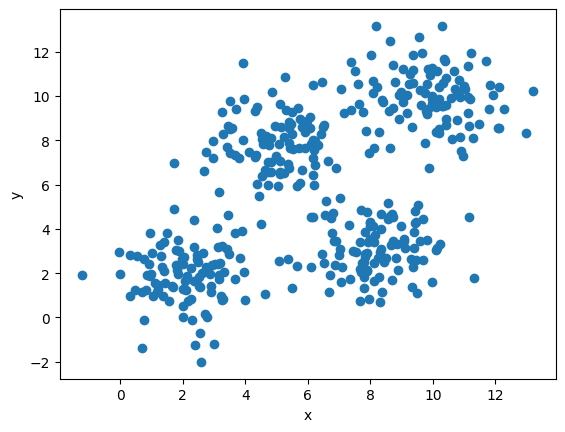

In [ ]:
plt.scatter(data['x'], data['y'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Se puede notar que hay cuatro grupos, pero en este caso están más dispersos que en el conjunto anterior.

### 3. Escalado (Fundamental)
---

Creamos nuestra matriz `X` y escalamos los datos lo cual es fundamental ya que tanto C-means como K-means pueden tener problemas al asignar los grupos si los datos no están en la misma escala.

In [ ]:
X = data[['x', 'y']].values

std = StandardScaler()
X_std = std.fit_transform(X)

### 4. Buscar el K más óptimo
---

Una vez nuestros datos están escalados, buscamos el K más óptimo.

In [ ]:
K_range, results, elbow_k = Elbow_BIC_iter_CMeans(Kmax=10, X=X_std, method='elbow', m=2.0, error=1e-5, maxiter=1000)
_, results_bic, bic_k = Elbow_BIC_iter_CMeans(Kmax=10, X=X_std, method='bic', m=2.0, error=1e-5, maxiter=1000)

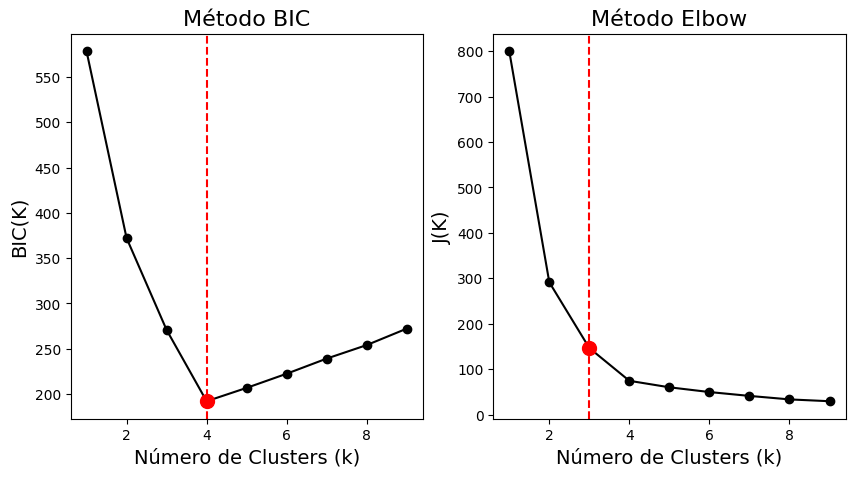

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, results_bic, "ko-")
plt.title("Método BIC", fontsize=16)
plt.xlabel("Número de Clusters (k)", fontsize=14)
plt.ylabel("BIC(K)", fontsize=14)
plt.axvline(x=bic_k, linestyle="--", color="red", label=f'Codo en k={bic_k}')
plt.scatter(bic_k, results_bic[bic_k - 1], color='red', s=100, zorder=3)

plt.subplot(1, 2, 2)
plt.plot(K_range, results, "ko-")
plt.title("Método Elbow", fontsize=16)
plt.xlabel("Número de Clusters (k)", fontsize=14)
plt.ylabel("J(K)", fontsize=14)
plt.axvline(x=elbow_k, linestyle="--", color="red", label=f'Codo en k={elbow_k}')
plt.scatter(elbow_k, results[elbow_k - 1], color='red', s=100, zorder=3)

plt.show()

Podemos ver que, en este caso, la función BIC ha encontrado la solución más idónea para este problema. Por lo que usaré su K para mi modelo.

### 5. Creación del modelo
---

A diferencia de otros modelos los cuales usabamos `fit` para entrenar, con C-means lo que hacemos es recoger los valores como si se tratará de una función. Los parámetros que usamos son los siguientes:

* data: Nuestra matriz X que debe estar traspuesta.
* c: E nº de K óbtimo.

Los siguientes valores son propuestos por el profesor y muchas veces no hace falta tocar.
* m: Exponenciación de la matriz.
* error: Criterio de parada.
* maxiter: Máximo nº de iteracciones.
* init: Matriz inicial.
* seed: Semilla de nº aleatorio.

Del resultado, solo nos interesan los centroides y la matriz de pertenencia que es la matriz de resultados de C-means.

In [ ]:
centroides, U, _, _, _, _, _  = Cmeans(data=X_std.T, c=bic_k, m=2.0, error=1e-5, maxiter=1000, init=None, seed=SEED)

Imprimimos la matriz de pertenencia.

In [ ]:
with np.printoptions(threshold=False):
  print(U)

[[0.9087865  0.76569493 0.03194702 ... 0.4262507  0.00320251 0.01409224]
 [0.03854815 0.11419856 0.13696928 ... 0.08624513 0.00303044 0.05502741]
 [0.01209392 0.02959996 0.72057451 ... 0.04567774 0.00198847 0.88701798]
 [0.04057144 0.09050655 0.11050918 ... 0.44182642 0.99177857 0.04386236]]


Ahora obtenemos los grupos de observación y el grado de pertenencia al grupo con mayor pertenencia.

In [ ]:
groups = np.argmax(U, axis=0)

maxU = np.amax(U, axis=0)

### 6. Comparación de resultados
---

Por último, comparamos los resultados obtenidos con los dados por el profesor.

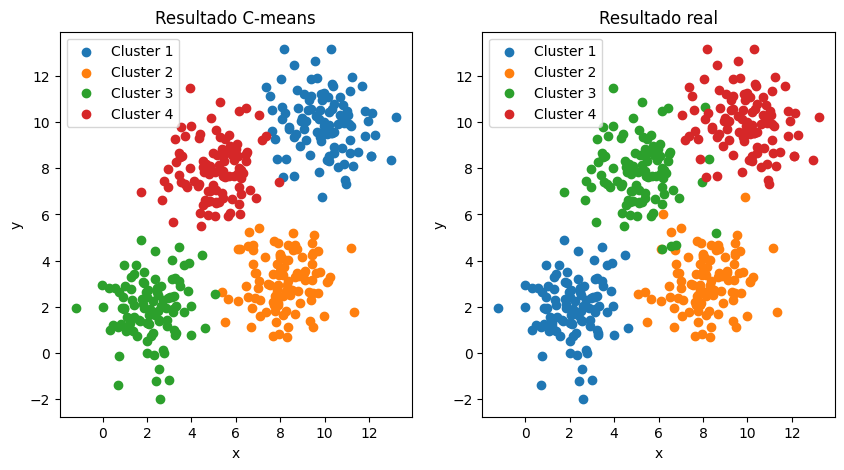

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
for k in range(0, bic_k):
  plt.scatter(X[groups==k, 0], X[groups==k, 1], label=f'Cluster {k+1}')

plt.title('Resultado C-means')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1, 2, 2)
for k in range(0, bic_k):
  plt.scatter(real_data[real_data['class']==k+1]['x'], real_data[real_data['class']==k+1]['y'], label=f'Cluster {k+1}')

plt.title('Resultado real')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Podemos notar que ocurre un poco como con K-means con la flor en el sentido de que los valores que estén muy cerca de un grupo, C-means lo clasificará dentro de ese grupo aun no perteneciendo realmente a dicho grupo.